# Data preparation

### Load in kinetic data as X

In [5]:
#####################################################################
############## read in kinetic data ##################################
#####################################################################

## read in kinetic data 
## into shape 
## x_train:  (data size, rows, columns)
## x_test:  (data size, rows, columns)

import numpy as np
import pandas as pd
import xlrd
import glob
#import numpy as np
import random
from matplotlib import pyplot as plt


# list of names of files 
file_names = []
# X is the data before preprocess
X = np.zeros((70, 70, 50))
# load in every excel file from kinetic_processed
for i, xls_file in enumerate(glob.glob("kinetic_processed/*")):
    # append into file_names list
    file_names.append(xls_file)
    #print(xls_file)
    # exclude column index and create panda dataframe
    dataframe = pd.read_excel(xls_file).iloc[:, 1:]
    # convert into numpy array and store into X
    matrix = dataframe.to_numpy()
    #print(matrix.shape)
    X[i] = matrix
    
print("total number of examples: ", X.shape[0])
print("dimension of one examples: ", X.shape[1], X.shape[2])
print("obtain array X with shape: ", X.shape)

total number of examples:  70
dimension of one examples:  70 50
obtain array X with shape:  (70, 70, 50)


### Cut X into hoof_set

In [6]:
#####################################################################
############## cut one matrix into four hoofs as: hoof_set  #########
#####################################################################

def cut_into_hoof(X):
    # init a new dataset to store hoofs: hoof_set 
    #hoof_set = np.zeros((280, 30, 20))
    hoof_set = []
    # loop through all 70 cows 
    for cow in range(70):
        # take one matrix 
        one_matrix = X[cow, :, :]

        # for each hoof, we crop it with height 30 and width 20 
        # top left hoof
        top_left = one_matrix[:30, :20] 
        # top right hoof 
        top_right = one_matrix[:30, -20:] 
        # bottom left hoof 
        bottom_left = one_matrix[-30:, :20] 
        # bottom right hoof 
        bottom_right = one_matrix[-30:, -20:] 

        #imshow(top_left)
        #imshow(top_right)
        #imshow(bottom_left)
        #imshow(bottom_right)
        hoof_set.append(top_left)
        hoof_set.append(top_right)
        hoof_set.append(bottom_left)
        hoof_set.append(bottom_right)
        
    return hoof_set 

#####################################################################
############## inspect each 4 hoofs in hoof_set  ####################
#####################################################################

"""
args
    -- check: index of cow that need to check 
    from 0-70
return 
    -- print four hoofs of that cow
"""
def check_4hoofs(check): 
    
    # base line 
    if check > 70:
        return "invalid number"
    
    check = check * 4
    
    # Here we create a figure instance, and two subplots
    fig = plt.figure(figsize = (5,20)) # width x height
    ax1 = fig.add_subplot(4, 1, 1) # row, column, position
    ax2 = fig.add_subplot(4, 1, 2)
    ax3 = fig.add_subplot(4, 1, 3)
    ax4 = fig.add_subplot(4, 1, 4)


    # We use ax parameter to tell seaborn which subplot to use for this plot
    ax1.imshow(hoof_set[check],  interpolation='nearest')
    ax2.imshow(hoof_set[check+1],  interpolation='nearest')
    ax3.imshow(hoof_set[check+2],  interpolation='nearest')
    ax4.imshow(hoof_set[check+3],  interpolation='nearest')

# use the cut function
hoof_set = cut_into_hoof(X)

#print("inspect hoof_set: ", len(hoof_set))
"""use function to check each 70 hoof sets (4 hoofs in each set)"""
#check_4hoofs(0)

'use function to check each 70 hoof sets (4 hoofs in each set)'

### Load in NRS score as Y

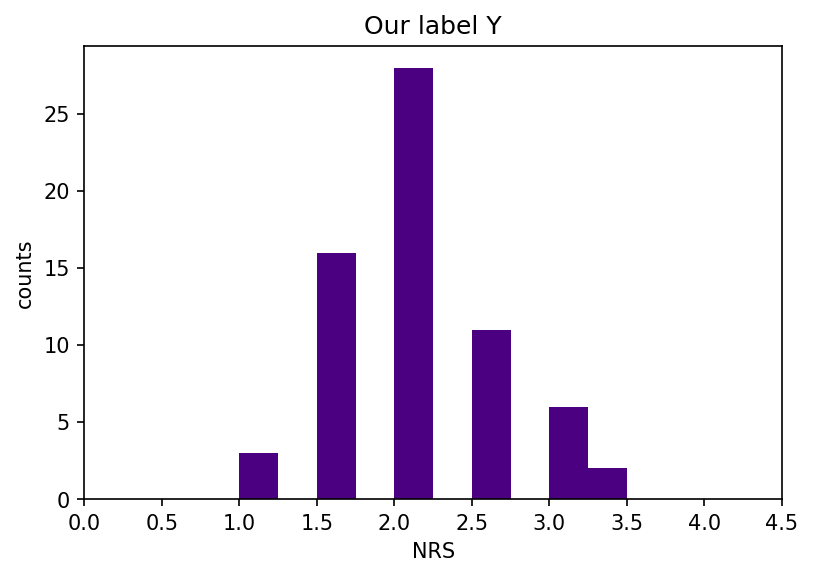

the length of Y:  66
any null data:  False
X.shape:  (66, 70, 50)
Y.shape:  (66,)


In [7]:

"""read in NRS label as Y"""
# name of the label file 
excel_name = 'labels.xlsx'
# read in by panda
df = pd.read_excel(excel_name)
# only need the second column, where we store the score
Y = df.iloc[:, 2]


"""clean some missing data where we labeled -1  and display the label distribution""" 
def clean_miss_nrs(X, Y):
    # exclude the missing data, where I put -1 for NRS, 
    X_clean = []
    Y_clean = []

    # if labeled as -1, not append that example/label
    for i, j in enumerate(Y): 
        if j == -1: 
            pass 
        else: 
            X_clean.append(X[i])
            Y_clean.append(Y[i])

    # store as numpy array and inspect the shape as X and Y
    return np.array(X_clean), np.array(Y_clean)


"""func to plot histogram"""
def plot_hist(data):
    plt.xlim([min(data)-1, max(data)+1])
    plt.hist(data, color="indigo")
    plt.title('Our label Y')
    plt.xlabel('NRS')
    plt.ylabel('counts')
    plt.show()

# use the function  
plt.figure(dpi=150)
X, Y = clean_miss_nrs(X, Y)
plot_hist(Y)
print("the length of Y: ", len(Y))
print("any null data: ", (Y==None).any())
print("X.shape: ", X.shape) 
print("Y.shape: ", Y.shape)

### Exclude hoofs that has no NRS

In [4]:

"""reload the data to find the index of label -1"""
def reload_for_missed_idx():
    # name of the label file 
    excel_name = 'labels.xlsx'
    # read in by panda
    df = pd.read_excel(excel_name)
    # only need the second column, where we store the score
    temp_Y = df.iloc[:, 2]

    # loop through temp_Y to find the index 
    # init list to store index 
    missed_idx = []
    for i, j in enumerate(temp_Y): 
        if j == -1: 
            missed_idx.append(i)
            
    return missed_idx
            
"""
function to create this list from missed_idx
now we know that the index that we need to discard in ls_hoof_int 
58 * 4 (and the next 3)
62 * 4 (and the next 3)
63 * 4 (and the next 3)
69 * 4 (and the next 3)
"""

def time4add3num(ls): 
    # init return ls 
    re_ls = []
    for i in ls: 
        time4 = i*4
        re_ls.append(time4)
        re_ls.append(time4+1)
        re_ls.append(time4+2)
        re_ls.append(time4+3)
    return re_ls 

""" firstly, discard 16 hoofs that have no NRS """
def discard_no_NRS(hoof_set, re_ls): 
    # init a list to store result 
    result = [] 
    # loop thourgh hoof_set
    for i in range(hoof_set.shape[0]): 
        # if is in the list of non-scored, discard
        if i in re_ls: 
            pass
        # if not in the re_ls, append
        else: 
            result.append(hoof_set[i])
            
    # return result as array 
    return np.array(result)


        
# inspect the list 
missed_idx = reload_for_missed_idx()
print("missed_idx: ", len(missed_idx), missed_idx)

# inspect this list 
re_ls = time4add3num(missed_idx)
print("re_ls: ", len(re_ls), re_ls)

# discard_no_NRS 
hoof_set_66 = discard_no_NRS(np.array(hoof_set), re_ls)
print("hoof_set_66: ", hoof_set_66.shape)

missed_idx:  4 [58, 62, 63, 69]
re_ls:  16 [232, 233, 234, 235, 248, 249, 250, 251, 252, 253, 254, 255, 276, 277, 278, 279]
hoof_set_66:  (264, 30, 20)


# Try to extract variables from the hoof to predict NRS

### extract force_area, max_force, mean_force, force_variance, force_skew to a list: vars_

In [5]:
"""to extract those five variables to the list four_vars with length (264*5)"""
def extract_var(hoof_set_66):
    # import skewness measure 
    from scipy.stats import skew
    # init vars
    vars = []
    
    # loop thourgh all matrices and create four_vars 
    for i in range(hoof_set_66.shape[0]):
        # take one matrix and try 
        one_mat = np.array(hoof_set_66[i], dtype = int)
        #print(one_mat) 

        # obtain all non-zero elements
        arr_no_0 = one_mat[np.where(one_mat!=0)]
        #print(arr_no_0.shape)

        # force_area is length 
        force_area = len(arr_no_0)
        # max force is the max in the list
        max_force = max(arr_no_0)
        # mean force is the mean value
        mean_force = np.mean(arr_no_0)
        # obtain variance of this list 
        force_variance = np.var(arr_no_0)
        # force skew
        force_skew = skew(sorted(arr_no_0))

        # check 
        #print("force_area, max_force, mean_force, force_variance: ", force_area, max_force, mean_force, force_variance)

        # append 
        vars.append(force_area)
        vars.append(max_force)
        vars.append(mean_force)
        vars.append(force_variance)
        vars.append(force_skew)
    
    return vars

# use this funciton and check len
vars_ = extract_var(hoof_set_66)
print("vars_: ", len(vars_), len(vars_)==264*5)

vars_:  1320 True


### Create two datasets: original_vars (66, 20), asymm_vars (66, 20)

In [6]:

"""
# helper func
args: 
    --a set of variable in one cow (four hoofs as a list)
return: 
    --a list of asymm index: abs(0.5 * ((X_hoof - X_hoof_ave)/(X_hoof + X_hoof_ave)))
"""
def asymm(ls_4):
    # compute average value
    x_ave = sum(ls_4)/4
    # init result list 
    result = [] 
    # loop thourgh the input list
    for i in ls_4: 
        # compute asymm index 
        asy_idx = abs(0.5*((i-x_ave)/(i+x_ave))) * 100
        # append to result
        result.append(asy_idx)
    return result


"""
# to create asymm_vars (20, 66) 
# for each cow each variable
# the asymmetric index is  abs(0.5 * ((X_hoof - X_hoof_ave)/(X_hoof + X_hoof_ave)))
# the data used is vars_
args: 
    --five_vars (a list)
return: 
    --asymm_vars numpy array with shape (20, 66) 
"""
def create_asymm(five_vars): 

    # init a result ls
    result = []
    # take every 20 elements as a cow 
    for i in range(0, len(five_vars), 20):
        cow = five_vars[i: i+20]
        #print(len(cow))
        # now we a cow as a list of 20 
        for var_ in range(5):
            # use asymm(ls_4) func
            one_hoof = asymm([cow[var_], cow[var_+5], cow[var_+10], cow[var_+15]])
            # append each value to result 
            for i in one_hoof: 
                result.append(i)
            
    return result

# create asymm as a list by the function 
asymm_vars = create_asymm(vars_)
# reshape the asymm as an array 
asymm_vars = np.array(asymm_vars).reshape((66, 20))

# to create original_vars (20, 66) 
# numpy reshape will do this
original_vars = np.array(vars_).reshape((66, 20))

# Correlate variables with NRS score

### Data preparation 

In [7]:
print("Have inputs: ")
print("original_vars: ", original_vars.shape)
print("asymm_vars: ", asymm_vars.shape)
#print("T_Y: ", len(T_Y))

Have inputs: 
original_vars:  (66, 20)
asymm_vars:  (66, 20)


### Standardization

In [8]:
# function to inspect dataset 
def inspect_stat(X):
    print("-------------------------")
    print("shape: ", X.shape)
    print("min(): ", X.min())
    print("max(): ", X.max())
    print("mean(): ", X.mean())
    print("std(): ", X.std())
    print("-------------------------")

# standize X 
def standard(X):
    temp = X - X.mean()
    X_nor = temp /  X.std()
    return X_nor

inspect_stat(original_vars)
original_vars_nor = standard(original_vars) 
inspect_stat(original_vars_nor)

inspect_stat(asymm_vars)
asymm_vars_nor = standard(asymm_vars) 
inspect_stat(asymm_vars_nor)

-------------------------
shape:  (66, 20)
min():  0.7355341457608107
max():  216372.1292925749
mean():  1728.4386594405726
std():  7704.9424426548885
-------------------------
-------------------------
shape:  (66, 20)
min():  -0.22423309948821601
max():  27.85792265557465
mean():  0.0
std():  0.9999999999999998
-------------------------
-------------------------
shape:  (66, 20)
min():  0.029994001199760045
max():  44.82039286586423
mean():  9.169874818188665
std():  8.024776604846215
-------------------------
-------------------------
shape:  (66, 20)
min():  -1.1389576641260357
max():  4.442555824687504
mean():  -7.266914343001025e-17
std():  0.9999999999999999
-------------------------


### Create binary label

length of label:  66
number of 1:  8
number of 0:  58


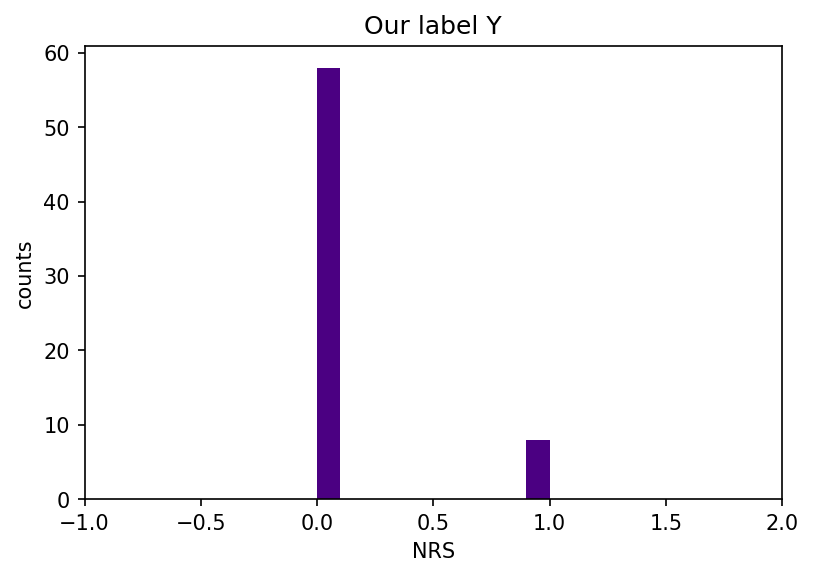

In [8]:
 """
arg: 
    -- list with 1, 2, 3 
return: 
    -- list with 0, 1
"""
def binarize_ls_hoof(ls): 
    # init new_ls
    new_ls = []
    # count 1 
    num_1 = 0
    # count 0
    num_0 = 0
    for i in ls: 
        if i > 2.5: 
            new_ls.append(1) 
            num_1 += 1
        else: 
            new_ls.append(0) 
            num_0 += 1
            
    print("length of label: ", len(new_ls))
    print("number of 1: ", num_1)
    print("number of 0: ", num_0)
    return new_ls

plt.figure(dpi=150)
# use the function and plot
Bi_Y = binarize_ls_hoof(Y)
plot_hist(Bi_Y)

In [11]:
"""spliting into train and test"""
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    # our X
    asymm_vars, 
    # our Y
    np.array(Bi_Y), 
    # training / testing ratio
    test_size=0.3, 
    random_state=12345)

print("y_test: ", y_test)

y_test:  [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0]


### Building model

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as keras
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization as BN
from keras import backend as k

In [13]:
# init input
input = Input(shape=(20,))

layer = Dense(32, activation='relu')(input)
layer = Dense(16, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='relu')(layer)
layer = Dense(1, activation='sigmoid')(layer)

# init model and plot summary
model = Model([input], layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable par

### Training and testing

In [14]:
def training(model, x_train, y_train, x_test, y_test, epochs):    
    # compile model 
    model.compile(optimizer=keras.optimizers.Adam(),
                  # define loss metric
                  loss=keras.losses.binary_crossentropy,
                  metrics=['accuracy'])

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    # store training histroy in history
    history = model.fit(    
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_test, y_test), 
        callbacks=[model_checkpoint_callback])
    
    # return history 
    return history


### Helper functions to give evaluation

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Function to plot learning curves
def plot_history(history):
    best_acc = max(history.history['accuracy'])
    best_epoch_acc = history.history['accuracy'].index(best_acc)
    print("--------------------------------------------------------------")
    print("Best training accuracy of: ", best_acc, " at epoch: ", best_epoch_acc)
    print()

    best_val = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val)
    print("--------------------------------------------------------------")
    print("Best validation accuracy of: ", best_val, " at epoch: ", best_epoch)
    print()

    # plot training history
    plt.figure(figsize=(8,8))

    # plot history for accuracy
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    # plot history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Function to transform y_pred to binary 
def prob_to_pred(y_pred): 
    result = [] 
    for i in y_pred: 
        if i[0] >= 0.5: 
            result.append(1) 
        else: 
            result.append(0) 
    return np.array(result)

# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print("Confusion Matrix: \n",
        confusion_matrix(y_test, y_pred))
      
    print ("Accuracy :\n ",
    accuracy_score(y_test,y_pred)*100)
      
    print("F1 :\n ",
    f1_score(y_test, y_pred, average='macro'))

In [16]:
# define callback to save best model
checkpoint_filepath = './best_model/checkpoint'
# training
history = training(model, x_train, y_train, x_test, y_test, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 569ms/step - loss: 2.0926 - accuracy: 0.1957 - val_loss: 1.8981 - val_accuracy: 0.3500
Epoch 2/200
2/2 [==============================] - 0s 84ms/step - loss: 1.6986 - accuracy: 0.3261 - val_loss: 1.4741 - val_accuracy: 0.4000
Epoch 3/200
2/2 [==============================] - 0s 88ms/step - loss: 1.2711 - accuracy: 0.3043 - val_loss: 1.1783 - val_accuracy: 0.5000
Epoch 4/200
2/2 [==============================] - 0s 41ms/step - loss: 1.2450 - accuracy: 0.3043 - val_loss: 0.9858 - val_accuracy: 0.5000
Epoch 5/200
2/2 [==============================] - 0s 92ms/step - loss: 0.9273 - accuracy: 0.4348 - val_loss: 0.8548 - val_accuracy: 0.6000
Epoch 6/200
2/2 [==============================] - 0s 110ms/step - loss: 0.8266 - accuracy: 0.5652 - val_loss: 0.7620 - val_accuracy: 0.6500
Epoch 7/200
2/2 [==============================] - 0s 39ms/step - loss: 0.7575 - accuracy: 0.5435 - val_loss: 0.7048 - val_accuracy: 0.6500
Epoch 8/200
2/2 [=

2/2 [==============================] - 0s 42ms/step - loss: 0.0915 - accuracy: 0.9565 - val_loss: 0.7795 - val_accuracy: 0.8000
Epoch 118/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0979 - accuracy: 0.9783 - val_loss: 0.7812 - val_accuracy: 0.8000
Epoch 119/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1139 - accuracy: 0.9565 - val_loss: 0.7849 - val_accuracy: 0.8000
Epoch 120/200
2/2 [==============================] - 0s 28ms/step - loss: 0.0996 - accuracy: 0.9348 - val_loss: 0.7903 - val_accuracy: 0.8000
Epoch 121/200
2/2 [==============================] - 0s 31ms/step - loss: 0.1023 - accuracy: 0.9348 - val_loss: 0.7943 - val_accuracy: 0.8000
Epoch 122/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1190 - accuracy: 0.9565 - val_loss: 0.7975 - val_accuracy: 0.8000
Epoch 123/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1199 - accuracy: 0.9348 - val_loss: 0.8017 - val_accuracy: 0.8000
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0567 - accuracy: 0.9783 - val_loss: 1.1446 - val_accuracy: 0.8000
Epoch 176/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0440 - accuracy: 0.9783 - val_loss: 1.1545 - val_accuracy: 0.8000
Epoch 177/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0364 - accuracy: 0.9783 - val_loss: 1.1602 - val_accuracy: 0.8000
Epoch 178/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0577 - accuracy: 0.9783 - val_loss: 1.1641 - val_accuracy: 0.8000
Epoch 179/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0451 - accuracy: 0.9783 - val_loss: 1.1724 - val_accuracy: 0.7500
Epoch 180/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0872 - accuracy: 0.9565 - val_loss: 1.1806 - val_accuracy: 0.7500
Epoch 181/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0453 - accuracy: 0.9783 - val_loss: 1.1909 - val_accuracy: 0.7500
Epoch 

--------------------------------------------------------------
Best training accuracy of:  0.97826087474823  at epoch:  83

--------------------------------------------------------------
Best validation accuracy of:  0.8500000238418579  at epoch:  11



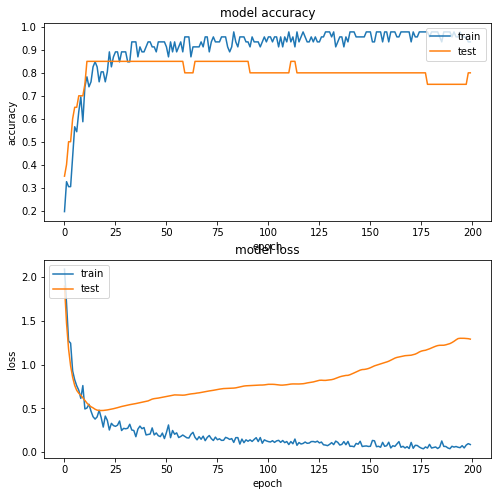

1/1 [==============================] - 0s 108ms/step
Confusion Matrix: 
 [[16  1]
 [ 2  1]]
Accuracy :
  85.0
F1 :
  0.6571428571428571


In [17]:
# load model 
model.load_weights(checkpoint_filepath)
# plot learning curve
plot_history(history)
# get prediction    
y_pred = model.predict(x_test)
# convert y_pred
y_pred = prob_to_pred(y_pred)
# print accuracy
cal_accuracy(y_test, y_pred)

### Larger model: 3 layer ANN

In [18]:
# init input
input = Input(shape=(20,))

layer = Dense(64, activation='relu')(input)
layer = Dropout(0.2)(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation='sigmoid')(layer)

# init model and plot summary
model = Model([input], layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                1344      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0   

In [19]:
# define callback to save best model
checkpoint_filepath = './best_model/checkpoint'
# training
history = training(model, x_train, y_train, x_test, y_test, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 254ms/step - loss: 3.4242 - accuracy: 0.3043 - val_loss: 1.6126 - val_accuracy: 0.3000
Epoch 2/200
2/2 [==============================] - 0s 96ms/step - loss: 1.8228 - accuracy: 0.5652 - val_loss: 0.7236 - val_accuracy: 0.5000
Epoch 3/200
2/2 [==============================] - 0s 97ms/step - loss: 1.2160 - accuracy: 0.6304 - val_loss: 0.3996 - val_accuracy: 0.9000
Epoch 4/200
2/2 [==============================] - 0s 45ms/step - loss: 1.0865 - accuracy: 0.6522 - val_loss: 0.3887 - val_accuracy: 0.8500
Epoch 5/200
2/2 [==============================] - 0s 36ms/step - loss: 0.8866 - accuracy: 0.6957 - val_loss: 0.4857 - val_accuracy: 0.8500
Epoch 6/200
2/2 [==============================] - 0s 38ms/step - loss: 0.6454 - accuracy: 0.7391 - val_loss: 0.5870 - val_accuracy: 0.8500
Epoch 7/200
2/2 [==============================] - 0s 40ms/step - loss: 0.6736 - accuracy: 0.8261 - val_loss: 0.6474 - val_accuracy: 0.8500
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 33ms/step - loss: 0.1325 - accuracy: 0.9348 - val_loss: 1.1950 - val_accuracy: 0.8500
Epoch 118/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0846 - accuracy: 0.9783 - val_loss: 1.1940 - val_accuracy: 0.8500
Epoch 119/200
2/2 [==============================] - 0s 32ms/step - loss: 0.1276 - accuracy: 0.9565 - val_loss: 1.1892 - val_accuracy: 0.8500
Epoch 120/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1180 - accuracy: 0.9565 - val_loss: 1.1887 - val_accuracy: 0.8000
Epoch 121/200
2/2 [==============================] - 0s 30ms/step - loss: 0.1269 - accuracy: 0.9348 - val_loss: 1.1906 - val_accuracy: 0.8500
Epoch 122/200
2/2 [==============================] - 0s 36ms/step - loss: 0.2490 - accuracy: 0.8696 - val_loss: 1.2007 - val_accuracy: 0.8500
Epoch 123/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1285 - accuracy: 0.9130 - val_loss: 1.2159 - val_accuracy: 0.9000
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0572 - accuracy: 0.9783 - val_loss: 1.5547 - val_accuracy: 0.8000
Epoch 176/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0734 - accuracy: 0.9348 - val_loss: 1.5550 - val_accuracy: 0.8000
Epoch 177/200
2/2 [==============================] - 0s 45ms/step - loss: 0.0557 - accuracy: 0.9783 - val_loss: 1.5577 - val_accuracy: 0.7500
Epoch 178/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0324 - accuracy: 0.9783 - val_loss: 1.5668 - val_accuracy: 0.7500
Epoch 179/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0616 - accuracy: 0.9565 - val_loss: 1.5760 - val_accuracy: 0.7500
Epoch 180/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0441 - accuracy: 1.0000 - val_loss: 1.5889 - val_accuracy: 0.8000
Epoch 181/200
2/2 [==============================] - 0s 41ms/step - loss: 0.1002 - accuracy: 0.9565 - val_loss: 1.6026 - val_accuracy: 0.8000
Epoch 

--------------------------------------------------------------
Best training accuracy of:  1.0  at epoch:  179

--------------------------------------------------------------
Best validation accuracy of:  0.8999999761581421  at epoch:  2



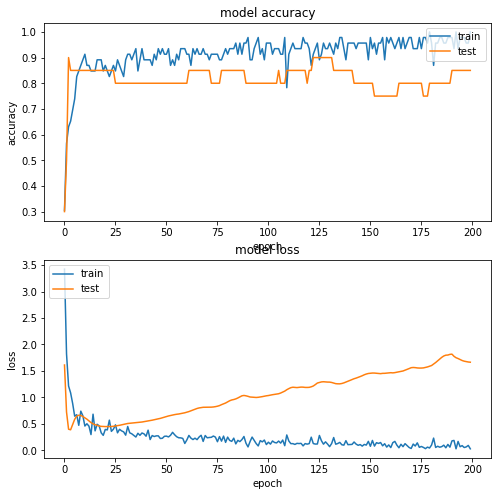

1/1 [==============================] - 0s 66ms/step
Confusion Matrix: 
 [[17  0]
 [ 2  1]]
Accuracy :
  90.0
F1 :
  0.7222222222222222


In [20]:
# load model 
model.load_weights(checkpoint_filepath)
# plot learning curve
plot_history(history)
# get prediction    
y_pred = model.predict(x_test)
# convert y_pred
y_pred = prob_to_pred(y_pred)
# print accuracy
cal_accuracy(y_test, y_pred)

### Try with another inputs (six raw variables)

In [21]:
"""spliting into train and test"""
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    # our X
    original_vars_nor, 
    # our Y
    np.array(Bi_Y), 
    # training / testing ratio
    test_size=0.3, 
    random_state=12345)

print("y_test: ", y_test)

y_test:  [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0]


### The first model

In [23]:
# init input
input = Input(shape=(20,))

layer = Dense(32, activation='relu')(input)
layer = Dense(16, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='relu')(layer)
layer = Dense(1, activation='sigmoid')(layer)

# init model and plot summary
model = Model([input], layer)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_12 (Dense)            (None, 32)                672       
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable p

In [24]:
# define callback to save best model
checkpoint_filepath = './best_model/checkpoint'
# training
history = training(model, x_train, y_train, x_test, y_test, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 248ms/step - loss: 0.7407 - accuracy: 0.3696 - val_loss: 0.7024 - val_accuracy: 0.4000
Epoch 2/200
2/2 [==============================] - 0s 104ms/step - loss: 0.7086 - accuracy: 0.4783 - val_loss: 0.6864 - val_accuracy: 0.6000
Epoch 3/200
2/2 [==============================] - 0s 93ms/step - loss: 0.6768 - accuracy: 0.7391 - val_loss: 0.6701 - val_accuracy: 0.8500
Epoch 4/200
2/2 [==============================] - 0s 34ms/step - loss: 0.6758 - accuracy: 0.7391 - val_loss: 0.6543 - val_accuracy: 0.8500
Epoch 5/200
2/2 [==============================] - 0s 35ms/step - loss: 0.6284 - accuracy: 0.8696 - val_loss: 0.6382 - val_accuracy: 0.8500
Epoch 6/200
2/2 [==============================] - 0s 39ms/step - loss: 0.6200 - accuracy: 0.8913 - val_loss: 0.6228 - val_accuracy: 0.8500
Epoch 7/200
2/2 [==============================] - 0s 38ms/step - loss: 0.6125 - accuracy: 0.8696 - val_loss: 0.6084 - val_accuracy: 0.8500
Epoch 8/200
2/2 [=

2/2 [==============================] - 0s 34ms/step - loss: 0.2495 - accuracy: 0.9348 - val_loss: 0.4887 - val_accuracy: 0.8500
Epoch 118/200
2/2 [==============================] - 0s 35ms/step - loss: 0.2391 - accuracy: 0.9348 - val_loss: 0.4882 - val_accuracy: 0.8500
Epoch 119/200
2/2 [==============================] - 0s 40ms/step - loss: 0.2386 - accuracy: 0.9348 - val_loss: 0.4874 - val_accuracy: 0.8500
Epoch 120/200
2/2 [==============================] - 0s 33ms/step - loss: 0.2327 - accuracy: 0.9348 - val_loss: 0.4875 - val_accuracy: 0.8500
Epoch 121/200
2/2 [==============================] - 0s 38ms/step - loss: 0.2065 - accuracy: 0.9348 - val_loss: 0.4886 - val_accuracy: 0.8500
Epoch 122/200
2/2 [==============================] - 0s 32ms/step - loss: 0.2312 - accuracy: 0.9348 - val_loss: 0.4903 - val_accuracy: 0.8500
Epoch 123/200
2/2 [==============================] - 0s 34ms/step - loss: 0.2120 - accuracy: 0.9348 - val_loss: 0.4928 - val_accuracy: 0.8500
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 51ms/step - loss: 0.2176 - accuracy: 0.9130 - val_loss: 0.5082 - val_accuracy: 0.8500
Epoch 176/200
2/2 [==============================] - 0s 43ms/step - loss: 0.2127 - accuracy: 0.9348 - val_loss: 0.5079 - val_accuracy: 0.8500
Epoch 177/200
2/2 [==============================] - 0s 44ms/step - loss: 0.1798 - accuracy: 0.9348 - val_loss: 0.5087 - val_accuracy: 0.8500
Epoch 178/200
2/2 [==============================] - 0s 42ms/step - loss: 0.2219 - accuracy: 0.9348 - val_loss: 0.5103 - val_accuracy: 0.8500
Epoch 179/200
2/2 [==============================] - 0s 41ms/step - loss: 0.2066 - accuracy: 0.9348 - val_loss: 0.5112 - val_accuracy: 0.8500
Epoch 180/200
2/2 [==============================] - 0s 40ms/step - loss: 0.1881 - accuracy: 0.9348 - val_loss: 0.5115 - val_accuracy: 0.8500
Epoch 181/200
2/2 [==============================] - 0s 40ms/step - loss: 0.2101 - accuracy: 0.9348 - val_loss: 0.5117 - val_accuracy: 0.8500
Epoch 

--------------------------------------------------------------
Best training accuracy of:  0.9347826242446899  at epoch:  67

--------------------------------------------------------------
Best validation accuracy of:  0.8500000238418579  at epoch:  2



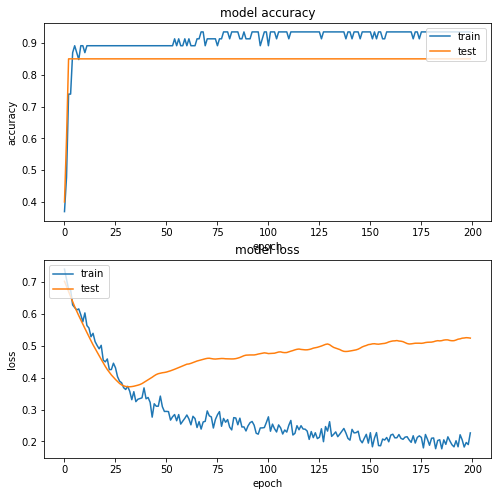

1/1 [==============================] - 0s 65ms/step
Confusion Matrix: 
 [[17  0]
 [ 3  0]]
Accuracy :
  85.0
F1 :
  0.45945945945945943


In [25]:
# load model 
model.load_weights(checkpoint_filepath)
# plot learning curve
plot_history(history)
# get prediction    
y_pred = model.predict(x_test)
# convert y_pred
y_pred = prob_to_pred(y_pred)
# print accuracy
cal_accuracy(y_test, y_pred)

### The second (larger one)

In [26]:
# init input
input = Input(shape=(20,))

layer = Dense(64, activation='relu')(input)
layer = Dropout(0.2)(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(16, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation='sigmoid')(layer)

# init model and plot summary
model = Model([input], layer)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_16 (Dense)            (None, 64)                1344      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0   

In [27]:
# define callback to save best model
checkpoint_filepath = './best_model/checkpoint'
# training
history = training(model, x_train, y_train, x_test, y_test, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 260ms/step - loss: 0.6685 - accuracy: 0.8043 - val_loss: 0.5840 - val_accuracy: 0.8500
Epoch 2/200
2/2 [==============================] - 0s 34ms/step - loss: 0.5982 - accuracy: 0.8261 - val_loss: 0.5647 - val_accuracy: 0.8500
Epoch 3/200
2/2 [==============================] - 0s 38ms/step - loss: 0.6094 - accuracy: 0.8261 - val_loss: 0.5432 - val_accuracy: 0.8500
Epoch 4/200
2/2 [==============================] - 0s 39ms/step - loss: 0.6214 - accuracy: 0.8696 - val_loss: 0.5229 - val_accuracy: 0.8500
Epoch 5/200
2/2 [==============================] - 0s 36ms/step - loss: 0.5332 - accuracy: 0.8913 - val_loss: 0.5020 - val_accuracy: 0.8500
Epoch 6/200
2/2 [==============================] - 0s 37ms/step - loss: 0.5506 - accuracy: 0.8913 - val_loss: 0.4798 - val_accuracy: 0.8500
Epoch 7/200
2/2 [==============================] - 0s 37ms/step - loss: 0.5567 - accuracy: 0.8913 - val_loss: 0.4616 - val_accuracy: 0.8500
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 31ms/step - loss: 0.2112 - accuracy: 0.9130 - val_loss: 0.5284 - val_accuracy: 0.8500
Epoch 118/200
2/2 [==============================] - 0s 30ms/step - loss: 0.2432 - accuracy: 0.9348 - val_loss: 0.5295 - val_accuracy: 0.8500
Epoch 119/200
2/2 [==============================] - 0s 30ms/step - loss: 0.2870 - accuracy: 0.9130 - val_loss: 0.5299 - val_accuracy: 0.8500
Epoch 120/200
2/2 [==============================] - 0s 30ms/step - loss: 0.2231 - accuracy: 0.9348 - val_loss: 0.5286 - val_accuracy: 0.8500
Epoch 121/200
2/2 [==============================] - 0s 30ms/step - loss: 0.2001 - accuracy: 0.9348 - val_loss: 0.5288 - val_accuracy: 0.8500
Epoch 122/200
2/2 [==============================] - 0s 37ms/step - loss: 0.2366 - accuracy: 0.9348 - val_loss: 0.5292 - val_accuracy: 0.8500
Epoch 123/200
2/2 [==============================] - 0s 31ms/step - loss: 0.2253 - accuracy: 0.9130 - val_loss: 0.5299 - val_accuracy: 0.8500
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 33ms/step - loss: 0.2025 - accuracy: 0.9348 - val_loss: 0.5934 - val_accuracy: 0.8500
Epoch 176/200
2/2 [==============================] - 0s 35ms/step - loss: 0.1864 - accuracy: 0.9348 - val_loss: 0.5957 - val_accuracy: 0.8500
Epoch 177/200
2/2 [==============================] - 0s 35ms/step - loss: 0.2015 - accuracy: 0.9348 - val_loss: 0.5987 - val_accuracy: 0.8500
Epoch 178/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1861 - accuracy: 0.9130 - val_loss: 0.6051 - val_accuracy: 0.8500
Epoch 179/200
2/2 [==============================] - 0s 34ms/step - loss: 0.1590 - accuracy: 0.9348 - val_loss: 0.6122 - val_accuracy: 0.8500
Epoch 180/200
2/2 [==============================] - 0s 33ms/step - loss: 0.1875 - accuracy: 0.9348 - val_loss: 0.6191 - val_accuracy: 0.8500
Epoch 181/200
2/2 [==============================] - 0s 32ms/step - loss: 0.2193 - accuracy: 0.9130 - val_loss: 0.6243 - val_accuracy: 0.8500
Epoch 

--------------------------------------------------------------
Best training accuracy of:  0.9347826242446899  at epoch:  60

--------------------------------------------------------------
Best validation accuracy of:  0.8500000238418579  at epoch:  0



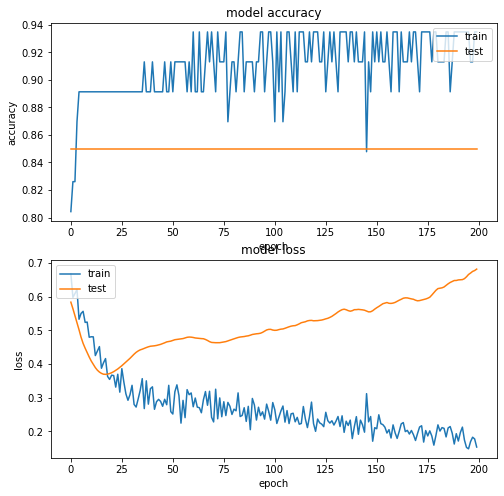

1/1 [==============================] - 0s 69ms/step
Confusion Matrix: 
 [[17  0]
 [ 3  0]]
Accuracy :
  85.0
F1 :
  0.45945945945945943


In [28]:
# load model 
model.load_weights(checkpoint_filepath)
# plot learning curve
plot_history(history)
# get prediction    
y_pred = model.predict(x_test)
# convert y_pred
y_pred = prob_to_pred(y_pred)
# print accuracy
cal_accuracy(y_test, y_pred)